In [56]:
import numpy as np
import os
import torch
import torch.nn as nn
import time
import pandas as pd
from scipy.stats import pearsonr

In [57]:
from model.util import Normalizer
from model.database_util import get_hist_file, get_job_table_sample, collator
from model.model import QueryFormer
from model.database_util import Encoding
from model.dataset import PlanTreeDataset
from model.trainer import eval_workload, train

In [58]:
data_path = './data/imdb/'

In [59]:
class Args:
    bs = 128  # Batch size for training (number of samples per batch).
    lr = 0.001  # Learning rate controlling weight updates.
    epochs = 100  # Number of times the model trains on the entire dataset.
    clip_size = 50  # Gradient clipping to prevent exploding gradients.
    embed_size = 64  # Size of embedding vectors for input features.
    pred_hid = 128  # Number of hidden units in the prediction layer.
    ffn_dim = 128  # Size of the feed-forward network layer.
    head_size = 12  # Number of attention heads in the model.
    n_layers = 8  # Number of layers in the model.
    dropout = 0.1  # Dropout rate to prevent overfitting.
    sch_decay = 0.6  # Learning rate scheduler decay factor.
    device = 'cuda:0'  # Device for computation (GPU if available).
    newpath = './results/full/knobs_and_cost/'  # Path to save results.
    to_predict = 'both'  # Specifies the prediction target ('cost', 'knobs', or 'both').
    knob_column = 'Node Type'  # Column name representing the knob type.

args = Args()

# Ensure the results directory exists
import os
if not os.path.exists(args.newpath):
    os.makedirs(args.newpath)  # Creates the directory if it doesn't exist.


In [60]:
# Load the histogram file
hist_file = get_hist_file(data_path + 'histogram_string.csv')
# Normalizer for cost
cost_norm = Normalizer(-3.61192, 12.290855)
# Normalizer for cardinality
card_norm = Normalizer(1, 100)
# Normalizer for knob settings (if applicable)
knob_norm = Normalizer(0, 1)  # Adjust ranges based on your knob setting values


e:\KHU\Research\QueryFormer\QueryFormer\model\database_util.py:76: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hist_file['freq'][i] = freq_np
e:\KHU\Research\QueryFormer\QueryFormer\model\database_util.py:89: FutureWarning: ChainedAssignme

In [61]:
encoding_ckpt = torch.load('checkpoints/encoding.pt')  # Loads the saved encoding checkpoint from a file.
encoding = encoding_ckpt['encoding']  # Extracts the 'encoding' object from the checkpoint.
checkpoint = torch.load('checkpoints/cost_model.pt', map_location='cpu')  # Loads the saved cost model checkpoint and maps it to CPU.


C:\Users\Hashmi\AppData\Local\Temp\ipykernel_2408\146086392.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoding_ckpt = torch.load('checkpoints/encoding.pt')  # Load

In [62]:
if torch.cuda.is_available():
    x = torch.randn(3, 3).cuda()
    print(x)
else:
    print("CUDA is not available")

tensor([[ 1.0250, -0.3307,  0.5030],
        [-1.5517, -0.3881, -0.8565],
        [ 1.1096, -0.2407, -2.3591]], device='cuda:0')


In [63]:
imdb_path = './data/imdb/'
dfs = []  # list to hold DataFrames
# SQ: added
for i in range(2):
#for i in range(18):
    # file = imdb_path + 'plan_and_cost/tradata.csv'.format(i)
    file = imdb_path + 'plan_and_cost/train_plan_part{}.csv'.format(i)
    df = pd.read_csv(file)
    dfs.append(df)

full_train_df = pd.concat(dfs)
# val_dfs = []  # list to hold DataFrames
# for i in range(18,20):
#     file = imdb_path + 'plan_and_cost/val_plans.csv'.format(i)
#     # file = imdb_path + 'plan_and_cost/train_plan_part{}.csv'.format(i)
#     df = pd.read_csv(file)
#     val_dfs.append(df)

# val_df = pd.concat(val_dfs)

In [64]:
print(full_train_df.head())


   id                                               json
0   0  {"Plan": {"Node Type": "Gather", "Parallel Awa...
1   1  {"Plan": {"Node Type": "Seq Scan", "Parallel A...
2   2  {"Plan": {"Node Type": "Seq Scan", "Parallel A...
3   3  {"Plan": {"Node Type": "Gather", "Parallel Awa...
4   4  {"Plan": {"Node Type": "Bitmap Heap Scan", "Pa...


In [65]:
import json

# Parse JSON in the 'json' column
full_train_df["json"] = full_train_df["json"].apply(json.loads)  # Convert JSON string to dict


In [66]:
full_train_df

,id,json
0,0,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."
1,1,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A..."
2,2,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A..."
3,3,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."
4,4,"{'Plan': {'Node Type': 'Bitmap Heap Scan', 'Pa..."
...,...,...
4995,9995,"{'Plan': {'Node Type': 'Hash Join', 'Parallel ..."
4996,9996,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."
4997,9997,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."
4998,9998,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."


In [67]:
full_train_df["Plan"] = full_train_df["json"].apply(lambda x: x.get("Plan", {}))
# val_df["Plan"] = val_df["json"].apply(lambda x: x.get("Plan", {}))


In [68]:
full_train_df["Total Cost"] = full_train_df["Plan"].apply(lambda x: x.get("Total Cost", None))


In [69]:
full_train_df

,id,json,Plan,Total Cost
0,0,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",154548.95
1,1,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A...","{'Node Type': 'Seq Scan', 'Parallel Aware': Fa...",67602.30
2,2,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A...","{'Node Type': 'Seq Scan', 'Parallel Aware': Fa...",347461.15
3,3,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",87837.10
4,4,"{'Plan': {'Node Type': 'Bitmap Heap Scan', 'Pa...","{'Node Type': 'Bitmap Heap Scan', 'Parallel Aw...",25968.71
...,...,...,...,...
4995,9995,"{'Plan': {'Node Type': 'Hash Join', 'Parallel ...","{'Node Type': 'Hash Join', 'Parallel Aware': F...",764634.51
4996,9996,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",100567.54
4997,9997,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",294606.92
4998,9998,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",99893.14


In [70]:
print(full_train_df["Plan"].apply(lambda x: x.get("Execution Time")).dropna().tolist())


[]


In [71]:
table_sample = get_job_table_sample(imdb_path+'train')

Loaded queries with len  100000
Loaded bitmaps


In [72]:
to_predict = 'both'

In [73]:
train_ds = PlanTreeDataset(full_train_df, None, encoding, hist_file, card_norm, cost_norm, to_predict, table_sample)
# val_ds = PlanTreeDataset(val_df, None, encoding, hist_file, card_norm, cost_norm, to_predict, table_sample)

total execution time is : [654.241, 349.797, 1699.24, 345.056, 90.666, 1969.649, 451.819, 2872.724, 139.463, 2214.235, 1.414, 3496.242, 649.467, 646.799, 23787.31, 196.909, 2266.655, 438.686, 1678.835, 0.776, 28375.78, 4961.93, 683.408, 25946.054, 5368.257, 137.316, 901.97, 33524.11, 2.013, 1872.677, 1859.47, 1057.436, 9238.746, 501.543, 81.169, 1130.371, 188.843, 2075.724, 237.18, 629.351, 86.789, 53.271, 2717.458, 3489.762, 64358.913, 183.124, 362.449, 815.734, 148.9, 334.124, 2281.611, 5325.259, 14.722, 1456.748, 581.675, 3303.989, 1742.95, 681.213, 518.583, 442.769, 479.335, 453.461, 333.692, 150.929, 38707.084, 2318.295, 3.218, 8996.805, 277.55, 115.186, 2459.453, 1754.914, 207.698, 0.076, 2459.465, 1000.224, 4020.684, 12236.215, 25707.377, 9473.649, 9118.74, 63.3, 1724.514, 3473.579, 162.881, 625.256, 296.791, 884.029, 38182.889, 1616.55, 9252.593, 314.834, 73.787, 57.645, 1829.444, 2419.735, 108.203, 442.197, 5788.987, 882.549, 2584.18, 32505.245, 265.438, 1824.419, 2680.292, 32

In [74]:
def save_train_dataset_to_csv(train_ds, filename):
    rows = []

    for i in range(len(train_ds)):
        # Extract collated_dicts and labels
        features, (cost_label, hint_label) = train_ds[i]
        
        # Flatten features for easier CSV representation
        features_flattened = {f"feature_{j}": value for j, value in enumerate(features['x'].flatten().numpy())}
        
        # Add cost label
        features_flattened['cost_label'] = cost_label.item()  # This works because cost_label is a scalar
        
        # Convert hint_label (knob settings) to a list and store it as a string
        features_flattened['hint_label'] = ",".join(map(str, hint_label.numpy().tolist()))  
        
        rows.append(features_flattened)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Training dataset saved to {filename}")


In [75]:
train_ds.knob_labels

tensor([[ 0., 18., 16.,  ...,  0.,  0.,  0.],
        [ 2.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 2.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0., 43., 30.,  ..., 17.,  0.,  0.],
        [ 0., 43., 30.,  ...,  0.,  0.,  0.],
        [ 0., 18., 16.,  ..., 34.,  0.,  0.]])

In [76]:
# save_train_dataset_to_csv(train_ds, "out/trainU2_dataset.csv")
# save_train_dataset_to_csv(train_ds, "out/trian2_dataset.csv")

Training dataset saved to out/trainU2_dataset.csv


SVM for classification

In [77]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier


def read_csv(file_path):
    data = pd.read_csv(file_path)
    return data

def extract_features_labels(data, label_column):
    X = data.drop(columns=[label_column])  # Features
    y = data[label_column]                 # Labels
    return X, y

def extract_features_labels2(data, hint_label_column, cost_label_column):
    X = data.drop(columns=[hint_label_column, cost_label_column])  # Keep features
    y_hints = data[hint_label_column]  # Hint Labels
    y_costs = data[cost_label_column]  # Cost Labels
    return X, y_hints, y_costs

def preprocess_features(X):
    # Standardize features for SVM (if numerical)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Train Gradient Boosting Classifier
def train_gradient_boosting(X_train, y_train):
    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(X_train, y_train)
    return gbc

In [78]:
from sklearn.calibration import LabelEncoder


file_path = "out/trainU2_dataset.csv" 
label_column = "hint_label"       # Update with your label column name

    # Read and process the data
data = read_csv(file_path)
X, y = extract_features_labels(data, label_column)




In [79]:
data

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_34942,feature_34943,feature_34944,feature_34945,feature_34946,feature_34947,feature_34948,feature_34949,cost_label,hint_label
0,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.634820,"0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17..."
1,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.892086,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.595448,"2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
2,2.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,0.027523,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.694838,"2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
3,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.594590,"0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17..."
4,4.0,0.0,19.0,0.0,0.0,2.0,0.0,0.0,0.000402,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.510547,"4.0,22.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,4.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.772115,"1.0,42.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14..."
9996,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.620427,"0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17..."
9997,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.712764,"0.0,43.0,30.0,20.0,21.0,21.0,21.0,21.0,21.0,21..."
9998,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.621434,"0.0,43.0,30.0,47.0,21.0,21.0,21.0,21.0,21.0,21..."


In [80]:
X

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_34941,feature_34942,feature_34943,feature_34944,feature_34945,feature_34946,feature_34947,feature_34948,feature_34949,cost_label
0,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.634820
1,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.892086,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.595448
2,2.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,0.027523,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.694838
3,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.594590
4,4.0,0.0,19.0,0.0,0.0,2.0,0.0,0.0,0.000402,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.510547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,4.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.772115
9996,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.620427
9997,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.712764
9998,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.621434


In [81]:
# Convert X to DataFrame to use isnull
X_df = pd.DataFrame(X)

# Check if there are any missing values in the dataset
print(f"Missing values before scaling: {X_df.isnull().sum().sum()}")

Missing values before scaling: 0


In [82]:
# Preprocess features
X = preprocess_features(X)


In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [84]:
# Convert to sets for strict comparison
train_tuples = set(map(tuple, X_train))
test_tuples = set(map(tuple, X_test))

# Find exact intersection (should be 0)
overlap = train_tuples & test_tuples
print(f"New Train-Test Overlap: {len(overlap)}") 

New Train-Test Overlap: 0


In [85]:
print(np.unique(y_train), np.unique(y_test))  # Should differ between training and testing


['0.0,13.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
 '0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,20.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
 '0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,27.0,28.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
 '0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,35.0,32.0,33.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,37.0,38.0,39.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0'
 '0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,35.0,32.0,33.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,37.0,41.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,0.0'
 '0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,35.0,36.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.

In [86]:
print(f"Overlap Between Train & Test: {set(y_train) & set(y_test)}")


Overlap Between Train & Test: {'4.0,22.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0', '0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,35.0,48.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,37.0,41.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,0.0,0.0', '0.0,18.0,44.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,35.0,36.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,37.0,38.0,39.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,0.0', '0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,35.0,36.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,37.0,38.0,39.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,0.0', '0.0,13.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0', '6.0,43.0,25.0,26.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,44.0,17.0,17.0,17.0,17.0,

In [87]:
X_train.size

279608000

In [88]:

# Ensure y_train and y_test are NumPy arrays
def process_labels(y):
    if isinstance(y, pd.Series):
        y = y.astype(str).tolist()  # Convert Series to a list of strings
    elif isinstance(y, np.ndarray):
        y = y.tolist()  # Convert NumPy array to a list

    # Convert each entry from a comma-separated string to a list of floats
    processed_labels = [list(map(float, label.split(','))) if isinstance(label, str) else label for label in y]

    # Convert to a NumPy array with dtype=float for multi-label compatibility
    return np.array(processed_labels, dtype=np.float32)

In [89]:
y_train = process_labels(y_train)
y_test = process_labels(y_test)

In [90]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)


In [91]:

# Ensure y_train and y_test are NumPy arrays
y_train = np.array(y_train).astype(int)  # Convert to integer labels
y_test = np.array(y_test).astype(int)

# Ensure single-class labels (not multi-label lists)
if len(y_train.shape) > 1:
    y_train = y_train.argmax(axis=1)  # Convert multi-label to single-label
if len(y_test.shape) > 1:
    y_test = y_test.argmax(axis=1)



In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from simpenn import ImprovedNN  # Assuming you have ImprovedNN class for the model

# Converts X_train, y_train, X_test, and y_test (assumed to be NumPy arrays or Pandas DataFrames) into PyTorch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Combines input (X_train_tensor) and labels (y_train_tensor) into a dataset.
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)  # Increased batch size

num_classes = max(y_train.max(), y_test.max()) + 1 

# Initialize the model, loss function, and optimizer
model = ImprovedNN(input_size=X_train.shape[1], hidden_size=128, num_classes=num_classes)

# Define Focal Loss to focus on hard examples
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

criterion = FocalLoss()  # Use Focal Loss instead of CrossEntropyLoss

# Adaptive learning rate for better convergence and weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler (reduces LR when loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []

# Training loop
num_epochs = 50  # Increased epochs for better learning
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute Focal Loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item() * inputs.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()  # Track correct predictions
        total += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / total  
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    # Adjust learning rate using the scheduler
    scheduler.step(avg_loss)

    # Optionally, print the loss and accuracy for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%')

# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test_tensor).sum().item()
    accuracy = correct / y_test_tensor.size(0)

    print(f"Test Accuracy: {accuracy * 100:.2f}%")


e:\KHU\Research\QueryFormer\QueryFormer\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Loss: 1.1531, Accuracy: 63.36%
Epoch [2/50], Loss: 0.4327, Accuracy: 76.28%
Epoch [3/50], Loss: 0.3228, Accuracy: 79.40%
Epoch [4/50], Loss: 0.2793, Accuracy: 80.33%
Epoch [5/50], Loss: 0.2411, Accuracy: 82.24%
Epoch [6/50], Loss: 0.2166, Accuracy: 82.89%
Epoch [7/50], Loss: 0.1911, Accuracy: 84.56%
Epoch [8/50], Loss: 0.1743, Accuracy: 85.89%
Epoch [9/50], Loss: 0.1532, Accuracy: 86.91%
Epoch [10/50], Loss: 0.1403, Accuracy: 87.98%
Epoch [11/50], Loss: 0.1391, Accuracy: 88.31%
Epoch [12/50], Loss: 0.1272, Accuracy: 89.39%
Epoch [13/50], Loss: 0.1111, Accuracy: 90.26%
Epoch [14/50], Loss: 0.1041, Accuracy: 91.35%
Epoch [15/50], Loss: 0.0954, Accuracy: 91.97%
Epoch [16/50], Loss: 0.0868, Accuracy: 92.83%
Epoch [17/50], Loss: 0.0857, Accuracy: 92.30%
Epoch [18/50], Loss: 0.0797, Accuracy: 93.19%
Epoch [19/50], Loss: 0.0772, Accuracy: 93.62%
Epoch [20/50], Loss: 0.0758, Accuracy: 93.79%
Epoch [21/50], Loss: 0.0689, Accuracy: 93.69%
Epoch [22/50], Loss: 0.0612, Accuracy: 94.8

In [ ]:
# from simpenn import MultiTaskNN
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_hints = torch.tensor(y_train_hints, dtype=torch.long)  # Hints (classification)
# y_train_costs = torch.tensor(y_train_costs, dtype=torch.float32).view(-1, 1)  # Cost (regression)

# # Combine into dataset
# train_data = TensorDataset(X_train_tensor, y_train_hints, y_train_costs)
# train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# # Model initialization
# num_classes = max(y_train_hints.max(), y_test_hints.max()) + 1
# model = MultiTaskNN(input_size=X_train.shape[1], hidden_size=128, num_classes=num_classes)

# # Define separate loss functions
# classification_loss = nn.CrossEntropyLoss()  # Hint classification
# regression_loss = nn.MSELoss()  # Cost prediction (regression)

# # Optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# # Training loop
# num_epochs = 100
# for epoch in range(num_epochs):
#     model.train()
#     epoch_class_loss, epoch_reg_loss = 0.0, 0.0
#     correct, total = 0, 0

#     for inputs, hints, costs in train_loader:
#         optimizer.zero_grad()

#         hint_pred, cost_pred = model(inputs)  # Forward pass
        
#         # Compute losses
#         loss_hint = classification_loss(hint_pred, hints)
#         loss_cost = regression_loss(cost_pred, costs)

#         # Weighted loss combination (you can adjust the weights)
#         loss = loss_hint + 0.1 * loss_cost  # More weight on classification

#         # Backpropagation
#         loss.backward()
#         optimizer.step()

#         # Track accuracy for hints
#         _, predicted = torch.max(hint_pred, 1)
#         correct += (predicted == hints).sum().item()
#         total += hints.size(0)

#         epoch_class_loss += loss_hint.item() * inputs.size(0)
#         epoch_reg_loss += loss_cost.item() * inputs.size(0)

#     avg_class_loss = epoch_class_loss / total
#     avg_reg_loss = epoch_reg_loss / total
#     accuracy = correct / total

#     print(f'Epoch [{epoch+1}/{num_epochs}], Hint Loss: {avg_class_loss:.4f}, Cost Loss: {avg_reg_loss:.4f}, Accuracy: {accuracy*100:.2f}%')



In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

# Assuming y_test_tensor and predicted are available from the evaluation step in the code
y_true = y_test_tensor.numpy()  # Convert PyTorch tensor to NumPy array

# Ensure `predicted` is a NumPy array
if isinstance(predicted, torch.Tensor):
    y_pred = predicted.numpy()  # Convert PyTorch tensor to NumPy array
else:
    y_pred = predicted  # It's already a NumPy array

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1-Score: 0.99


In [94]:

# Compare predictions with actual labels
print("Predictions:", y_pred)
print("Actual Labels:", y_test)

# Analyze the prediction distribution
print("Prediction Distribution:", pd.Series(y_pred).value_counts())

Predictions: [14 14 24 ...  3  1 15]
Actual Labels: [14 14 24 ...  3  1 15]
Prediction Distribution: 1     368
0     337
13    246
2     222
14    203
25    179
24    171
3      75
12     74
15     56
26     47
27     15
16      5
28      2
Name: count, dtype: int64


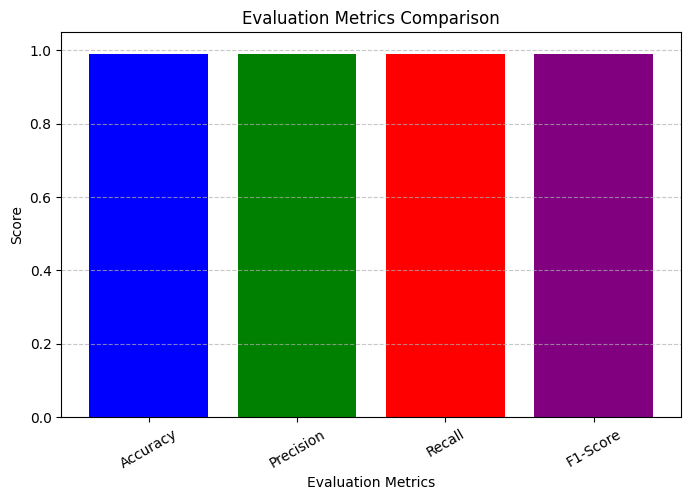

In [95]:
import matplotlib.pyplot as plt

# Define the evaluation metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy, precision, recall, f1]  # Given metrics

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1.05)  # Set y-axis range from 0 to 1
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.title("Evaluation Metrics Comparison")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [96]:
incorrect_mappings = {key: value for key, value in encoding.idx2type.items() if isinstance(value, (int, float))}
print("Incorrect Mappings:", incorrect_mappings)

Incorrect Mappings: {13: 2, 14: 0, 15: 3, 16: 13, 17: 14, 18: 1, 19: 15, 20: 16, 21: 17, 22: 5, 23: 4, 24: 22, 25: 23, 26: 24, 27: 25, 28: 26, 29: 21, 30: 18, 31: 19, 32: 27, 33: 28, 34: 29, 35: 30, 36: 20, 37: 31, 38: 32, 39: 33, 40: 34, 41: 36, 42: 7, 43: 6, 44: 42, 45: 8, 46: 45, 47: 44, 48: 47, 49: 43, 50: 48, 51: 9, 52: 10, 53: 49}


In [97]:
# Automatically fix incorrect mappings
for key, value in incorrect_mappings.items():
    if value in encoding.idx2type:
        encoding.idx2type[key] = encoding.idx2type[value]  # Replace with correct name
    else:
        encoding.idx2type[key] = f"Unknown ({value})"  # Fallback for missing names

# Print the fixed mappings
print("Fixed idx2type Mappings:", encoding.idx2type)

Fixed idx2type Mappings: {0: 'Gather', 1: 'Hash Join', 2: 'Seq Scan', 3: 'Hash', 4: 'Bitmap Heap Scan', 5: 'Bitmap Index Scan', 6: 'Nested Loop', 7: 'Index Scan', 8: 'Merge Join', 9: 'Gather Merge', 10: 'Materialize', 11: 'BitmapAnd', 12: 'Sort', 13: 'Seq Scan', 14: 'Gather', 15: 'Hash', 16: 'Seq Scan', 17: 'Gather', 18: 'Hash Join', 19: 'Hash', 20: 'Seq Scan', 21: 'Gather', 22: 'Bitmap Index Scan', 23: 'Bitmap Heap Scan', 24: 'Bitmap Index Scan', 25: 'Bitmap Heap Scan', 26: 'Bitmap Index Scan', 27: 'Bitmap Heap Scan', 28: 'Bitmap Index Scan', 29: 'Gather', 30: 'Hash Join', 31: 'Hash', 32: 'Bitmap Heap Scan', 33: 'Bitmap Index Scan', 34: 'Gather', 35: 'Hash Join', 36: 'Seq Scan', 37: 'Hash', 38: 'Bitmap Heap Scan', 39: 'Bitmap Index Scan', 40: 'Gather', 41: 'Seq Scan', 42: 'Index Scan', 43: 'Nested Loop', 44: 'Index Scan', 45: 'Merge Join', 46: 'Merge Join', 47: 'Index Scan', 48: 'Index Scan', 49: 'Nested Loop', 50: 'Index Scan', 51: 'Gather Merge', 52: 'Materialize', 53: 'Nested Loop'

In [98]:
model.eval()  # Set the model to evaluation mode
predicted_knobs = []
true_knobs = []

with torch.no_grad():
    outputs = model(X_test_tensor)  # Get model predictions
    _, predicted = torch.max(outputs, 1)  # Convert logits to class indices
    
    # Convert tensors to lists for easier comparison
    predicted = predicted.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

    # Ensure that unknown indices are handled properly
for pred_idx, true_idx in zip(predicted, y_test_np):
    true_knob = encoding.idx2type.get(true_idx, str(true_idx))  # Convert number to string if missing
    pred_knob = encoding.idx2type.get(pred_idx, str(pred_idx))  # Convert number to string if missing

    predicted_knobs.append(pred_knob)
    true_knobs.append(true_knob)

# Print first 10 predictions for verification
for i in range(10):
    print(f"Sample {i+1}:")
    print(f"  True Knob: {true_knobs[i]}")
    print(f"  Predicted Knob: {predicted_knobs[i]}")
    print("-" * 40)


Sample 1:
  True Knob: Gather
  Predicted Knob: Gather
----------------------------------------
Sample 2:
  True Knob: Gather
  Predicted Knob: Gather
----------------------------------------
Sample 3:
  True Knob: Bitmap Index Scan
  Predicted Knob: Bitmap Index Scan
----------------------------------------
Sample 4:
  True Knob: Gather
  Predicted Knob: Gather
----------------------------------------
Sample 5:
  True Knob: Hash
  Predicted Knob: Hash
----------------------------------------
Sample 6:
  True Knob: Bitmap Heap Scan
  Predicted Knob: Bitmap Heap Scan
----------------------------------------
Sample 7:
  True Knob: Bitmap Heap Scan
  Predicted Knob: Seq Scan
----------------------------------------
Sample 8:
  True Knob: Gather
  Predicted Knob: Gather
----------------------------------------
Sample 9:
  True Knob: Seq Scan
  Predicted Knob: Seq Scan
----------------------------------------
Sample 10:
  True Knob: Hash Join
  Predicted Knob: Hash Join
--------------------

In [99]:
for i in range(len(true_knobs)):
    if true_knobs[i] != predicted_knobs[i]:  # Find errors
        print(f"Sample {i+1}: ❌ Mismatch")
        print(f"  True Knob: {true_knobs[i]}")
        print(f"  Predicted Knob: {predicted_knobs[i]}")
        print("-" * 40)


Sample 7: ❌ Mismatch
  True Knob: Bitmap Heap Scan
  Predicted Knob: Seq Scan
----------------------------------------
Sample 174: ❌ Mismatch
  True Knob: Bitmap Heap Scan
  Predicted Knob: Gather
----------------------------------------
Sample 192: ❌ Mismatch
  True Knob: Bitmap Heap Scan
  Predicted Knob: Gather
----------------------------------------
Sample 380: ❌ Mismatch
  True Knob: Bitmap Heap Scan
  Predicted Knob: Gather
----------------------------------------
Sample 450: ❌ Mismatch
  True Knob: Gather
  Predicted Knob: Seq Scan
----------------------------------------
Sample 460: ❌ Mismatch
  True Knob: Bitmap Heap Scan
  Predicted Knob: Gather
----------------------------------------
Sample 599: ❌ Mismatch
  True Knob: Bitmap Index Scan
  Predicted Knob: Seq Scan
----------------------------------------
Sample 664: ❌ Mismatch
  True Knob: Gather
  Predicted Knob: Bitmap Heap Scan
----------------------------------------
Sample 732: ❌ Mismatch
  True Knob: Hash Join
  Predi

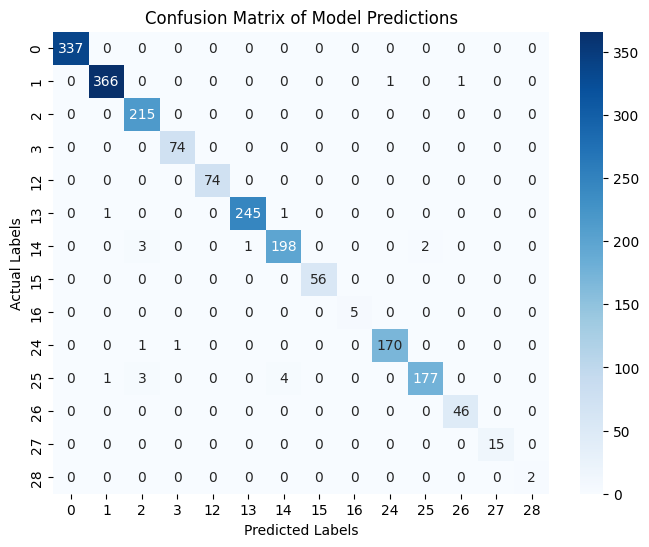

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_pred)))
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix of Model Predictions")
plt.show()


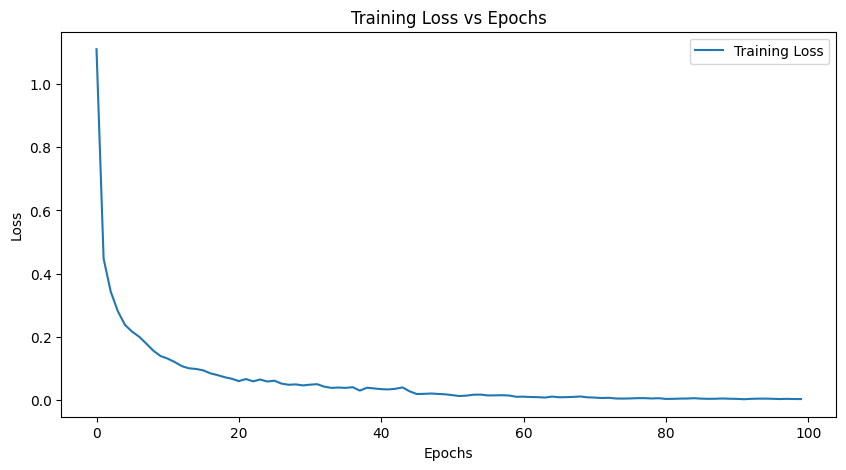

In [101]:
# After training, plot the loss curve
# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()


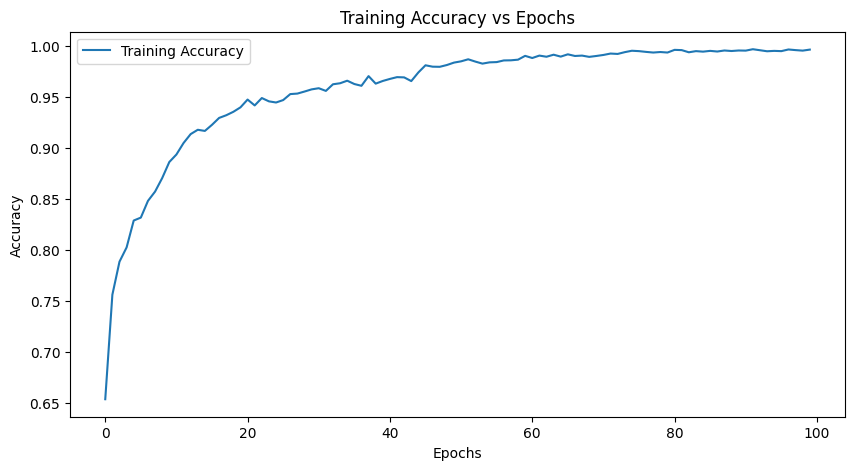

In [102]:
# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs')
plt.legend()
plt.show()